The goal of this notebook is to investigate our 2nd current working hypothesis, which states that peak I(EEG;TIA) optimal lag converges at 500 ms or later. I will try to get this to work with subject 2 for now; if it works I will expand it to other subjects. 

In [1]:
import mne
from pathlib import Path
import numpy as np
import neural_mi as nmi
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm
from sklearn.preprocessing import StandardScaler
import random

In [2]:
# Prepare the data
data_path = Path("../data/raw/P1-20251027T182958Z-1-001/P1/")
file_path = data_path / "binepochs filtered ICArej P1AvgBOS2.set"
epochs = mne.io.read_epochs_eeglab(file_path)

auditory_epochs = epochs[::2]
tactile_epochs = epochs[1::2]

X = auditory_epochs.get_data()  # shape (n_epochs, n_channels, n_times)
sfreq = auditory_epochs.info['sfreq']  # Sampling frequency

Extracting parameters from c:\Users\Rinta\Documents\Classes\PSYC 4745\Research Project\CISI Repo\Phys-Cog-CISI-Group\notebooks\..\data\raw\P1-20251027T182958Z-1-001\P1\binepochs filtered ICArej P1AvgBOS2.set...
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Ready.


C:\Users\Rinta\AppData\Local\Temp\ipykernel_24620\4221827485.py:4: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(file_path)


In [3]:
# epochs.plot(n_epochs=120, n_channels=2)

In [4]:
chan_a = 'FZ'
chan_b = 'Cz'

idx_a = auditory_epochs.ch_names.index(chan_a)
idx_b = auditory_epochs.ch_names.index(chan_b)

x_raw = X[:, idx_a, :]  # shape (n_epochs, n_times)
y_raw = X[:, idx_b, :]  # shape (n_epochs, n_times)

x_concat = x_raw.reshape(-1)  # shape (n_epochs * n_times,)
y_concat = y_raw.reshape(-1)  # shape (n_epochs * n_times,

In [5]:
# Base parameters for our MI estimator. We'll use a simple MLP.
BASE_PARAMS = {
    'embedding_dim': 16,
    'hidden_dim': 32,
    'n_layers': 2,
    'learning_rate': 1e-3,
    'batch_size': 128,
    'n_epochs': 30,
    'patience': 15,
}

# Plotting function for X and Y
def plot_data(x, y, title=None, xlim=100):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(x.T, label=r'$x(t)$')
    ax.plot(y.T, label=r'$y(t)$')
    ax.set_xlabel('Timepoints')
    ax.set_ylabel('Value')
    if title:
        ax.set_title(title)
    ax.set_xlim(0, xlim)
    ax.legend()
    plt.show()

In [6]:
import torch, time
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Warm-up
for _ in range(3):
    torch.matmul(torch.randn(2048, 2048, device=device),
                 torch.randn(2048, 2048, device=device))

torch.cuda.synchronize()

# GPU benchmark
start = time.time()
for _ in range(100):
    a = torch.randn(2048, 2048, device=device)
    b = torch.randn(2048, 2048, device=device)
    c = torch.matmul(a, b)
torch.cuda.synchronize()
print(f"GPU batch run: {time.time() - start:.4f} seconds")

# CPU benchmark
start = time.time()
for _ in range(100):
    a_cpu = torch.randn(2048, 2048)
    b_cpu = torch.randn(2048, 2048)
    c_cpu = torch.matmul(a_cpu, b_cpu)
print(f"CPU batch run: {time.time() - start:.4f} seconds")

print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())
print(torch.backends.cudnn.is_available())
print(torch.version.cuda)

PyTorch version: 2.6.0+cu124
CUDA available: True
GPU name: NVIDIA GeForce RTX 3060 Laptop GPU
Using device: cuda
GPU batch run: 0.2961 seconds
CPU batch run: 11.2789 seconds
NVIDIA GeForce RTX 3060 Laptop GPU
True
True
12.4


Using matplotlib as 2D backend.


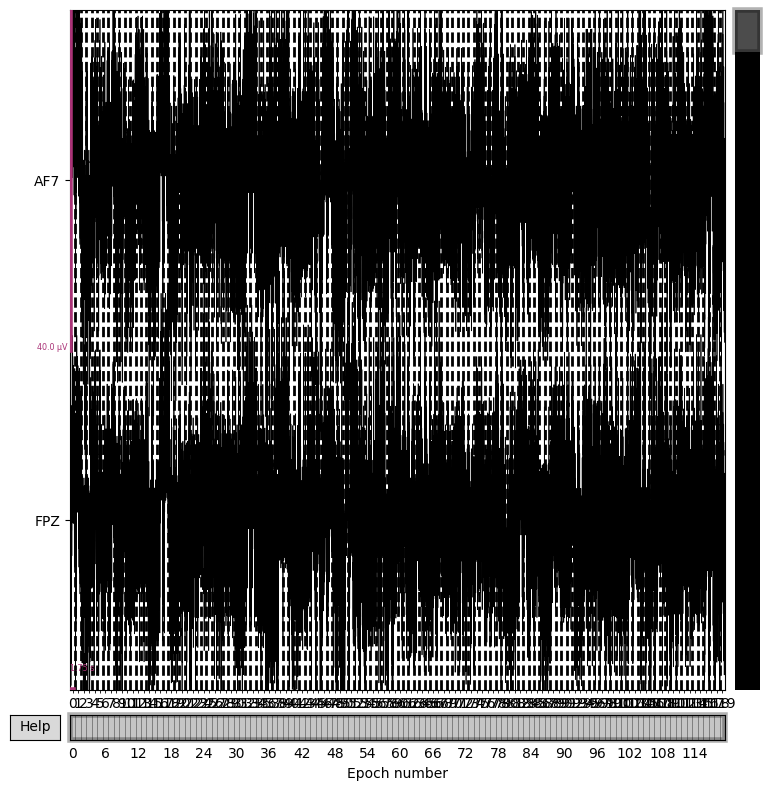

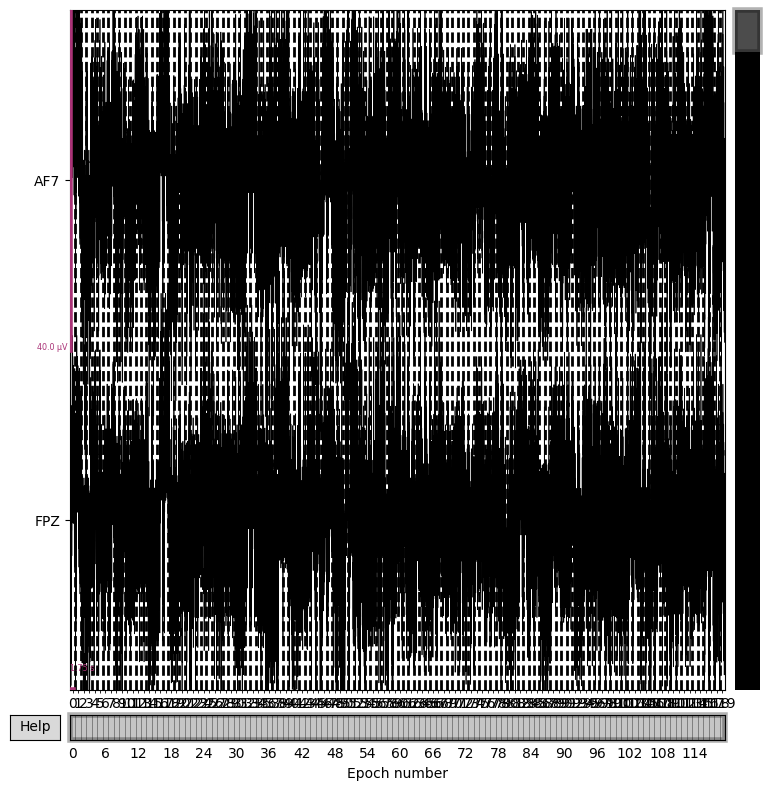

In [10]:
epochs.plot(n_epochs=120, n_channels=2)

In [7]:
raw_results = nmi.run(
    x_data=x_raw,
    y_data=y_raw,
    mode='lag',
    processor_type_x='continuous',
    processor_params_x={'window_size': 1},
    processor_type_y='continuous',
    processor_params_y={'window_size': 1},
    lag_range=range(450, 750, 12),
    base_params=BASE_PARAMS,
    n_workers=4,
    random_seed=42
)

2025-10-27 19:54:51 - neural_mi - WARNING - Reproducibility with random_seed is not guaranteed with n_workers > 1.
2025-10-27 19:54:51 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-10-27 19:54:51 - neural_mi - INFO - Preparing 25 tasks for lag analysis.
2025-10-27 19:54:51 - neural_mi - INFO - Starting parameter sweep with 4 workers...


Parameter Sweep Progress:   0%|          | 0/25 [00:00<?, ?task/s]

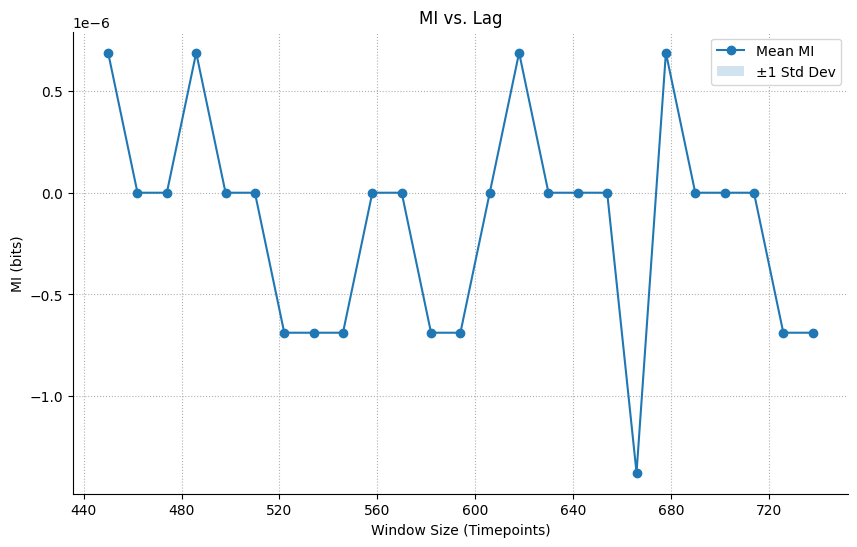

In [8]:
ax = raw_results.plot(show=False)
ax.set_xlabel('Window Size (Timepoints)')
ax.legend()
plt.show()

Doesn't make much sense, but that was expected. There are many directions for improvement (low-pass filter, loop over subjects and channels)

In [15]:
# ---------------- CONFIGURATION ---------------- #
DATA_PATH = Path("../data/raw/P1-20251027T182958Z-1-001/P1/")
FILE_NAME = "binepochs filtered ICArej P1AvgBOS2.set"
OUTPUT_DIR = Path("../results/mi_lag_analysis_P1/")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

N_PAIRS = 10  # number of random channel pairs to analyze
BANDPASS_RANGE = (1.0, 30.0)  # Hz
LAG_RANGE = range(400, 800, 10)  # in timepoints (depends on your sampling rate)

# NeuralMI base parameters
BASE_PARAMS = {
    'embedding_dim': 16,
    'hidden_dim': 32,
    'n_layers': 2,
    'learning_rate': 1e-3,
    'batch_size': 128,
    'n_epochs': 30,
    'patience': 15,
}

# ------------------------------------------------ #

# === 1. Load and preprocess data ===
file_path = DATA_PATH / FILE_NAME
epochs = mne.io.read_epochs_eeglab(file_path)

# Split auditory/tactile conditions (optional)
auditory_epochs = epochs[::2]
tactile_epochs = epochs[1::2]
sfreq = auditory_epochs.info['sfreq']

# Apply band-pass filter (in-place)
auditory_epochs.filter(*BANDPASS_RANGE, fir_design='firwin', verbose=False)

# Extract data array
X = auditory_epochs.get_data()  # shape: (n_epochs, n_channels, n_times)
ch_names = auditory_epochs.ch_names

print(f"Data shape: {X.shape}, Sampling rate: {sfreq} Hz")

# === 2. Choose random pairs ===
pairs = []
while len(pairs) < N_PAIRS:
    a, b = random.sample(ch_names, 2)
    if (a, b) not in pairs and (b, a) not in pairs:
        pairs.append((a, b))

print("Channel pairs:", pairs)

Extracting parameters from c:\Users\Rinta\Documents\Classes\PSYC 4745\Research Project\CISI Repo\Phys-Cog-CISI-Group\notebooks\..\data\raw\P1-20251027T182958Z-1-001\P1\binepochs filtered ICArej P1AvgBOS2.set...
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Ready.


C:\Users\Rinta\AppData\Local\Temp\ipykernel_24620\803706934.py:26: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(file_path)


Data shape: (60, 32, 1792), Sampling rate: 512.0 Hz
Channel pairs: [('F4', 'FPZ'), ('TP7', 'C4'), ('Cz', 'FC5'), ('FZ', 'F3'), ('P6', 'AF8'), ('FPZ', 'F3'), ('C3', 'Cz'), ('FPZ', 'T7'), ('P2', 'Cz'), ('POz', 'TP7')]


Analyzing random pairs:   0%|          | 0/10 [00:00<?, ?it/s]

2025-10-27 20:15:23 - neural_mi - WARNING - Reproducibility with random_seed is not guaranteed with n_workers > 1.
2025-10-27 20:15:23 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-10-27 20:15:23 - neural_mi - INFO - Preparing 40 tasks for lag analysis.
2025-10-27 20:15:23 - neural_mi - INFO - Starting parameter sweep with 8 workers...


Parameter Sweep Progress:   0%|          | 0/40 [00:00<?, ?task/s]

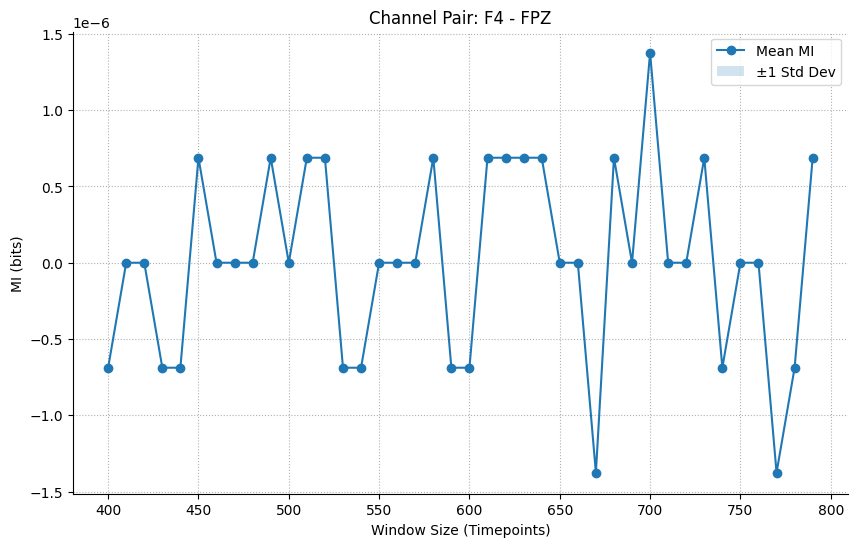

2025-10-27 20:16:02 - neural_mi - WARNING - Reproducibility with random_seed is not guaranteed with n_workers > 1.
2025-10-27 20:16:02 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-10-27 20:16:02 - neural_mi - INFO - Preparing 40 tasks for lag analysis.
2025-10-27 20:16:02 - neural_mi - INFO - Starting parameter sweep with 8 workers...


Parameter Sweep Progress:   0%|          | 0/40 [00:00<?, ?task/s]

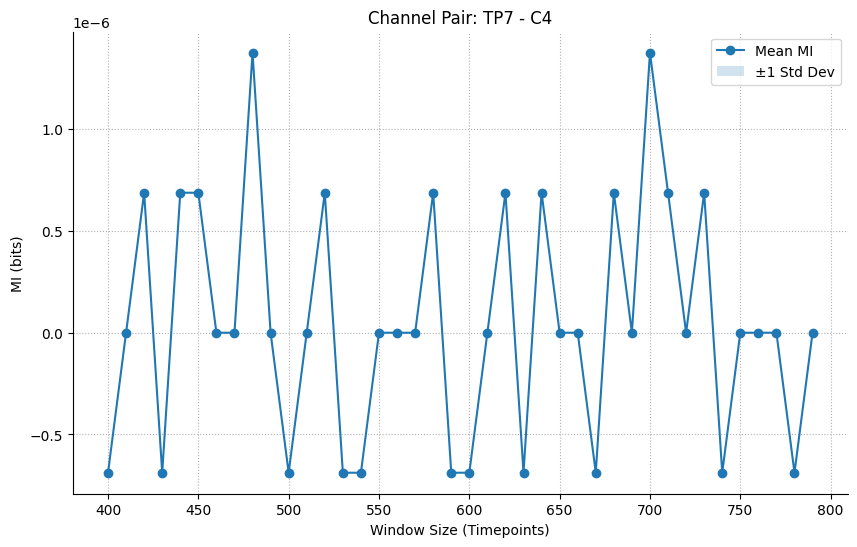

2025-10-27 20:16:46 - neural_mi - WARNING - Reproducibility with random_seed is not guaranteed with n_workers > 1.
2025-10-27 20:16:47 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-10-27 20:16:47 - neural_mi - INFO - Preparing 40 tasks for lag analysis.
2025-10-27 20:16:47 - neural_mi - INFO - Starting parameter sweep with 8 workers...


Parameter Sweep Progress:   0%|          | 0/40 [00:00<?, ?task/s]

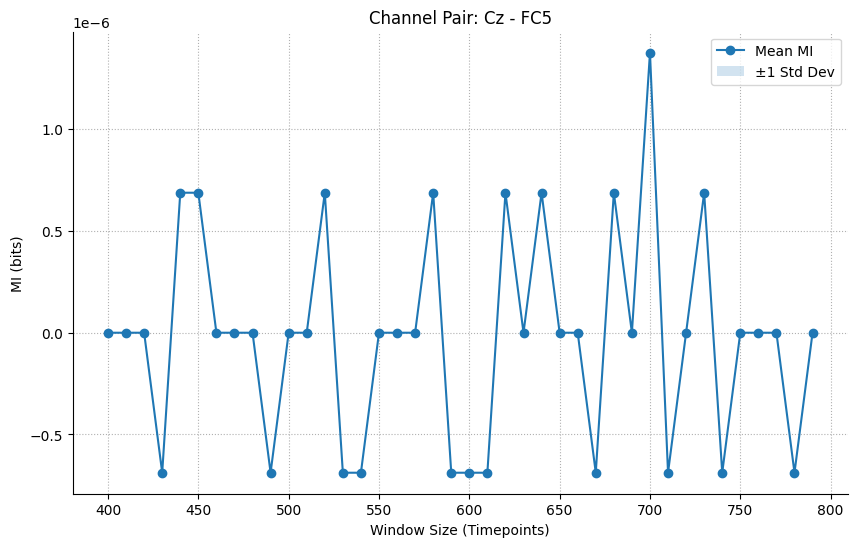

2025-10-27 20:17:24 - neural_mi - WARNING - Reproducibility with random_seed is not guaranteed with n_workers > 1.
2025-10-27 20:17:24 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-10-27 20:17:24 - neural_mi - INFO - Preparing 40 tasks for lag analysis.
2025-10-27 20:17:24 - neural_mi - INFO - Starting parameter sweep with 8 workers...


Parameter Sweep Progress:   0%|          | 0/40 [00:00<?, ?task/s]

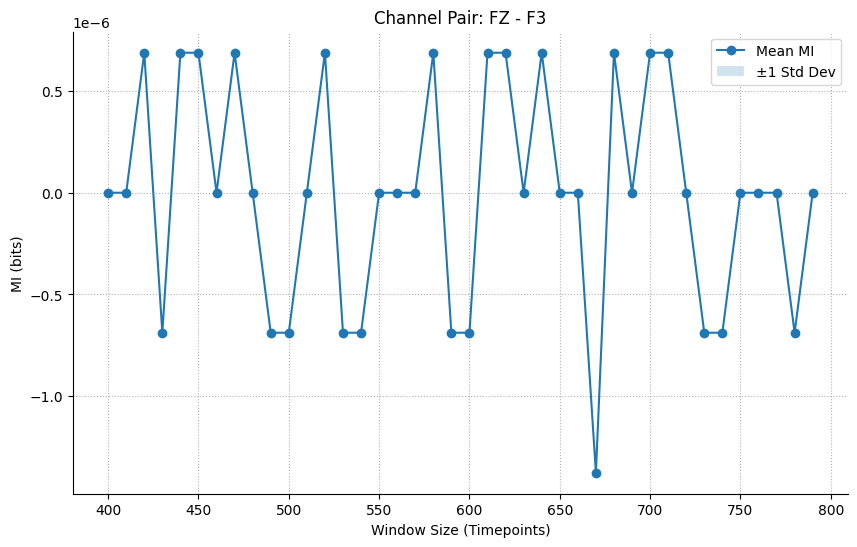

2025-10-27 20:18:02 - neural_mi - WARNING - Reproducibility with random_seed is not guaranteed with n_workers > 1.
2025-10-27 20:18:02 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-10-27 20:18:02 - neural_mi - INFO - Preparing 40 tasks for lag analysis.
2025-10-27 20:18:02 - neural_mi - INFO - Starting parameter sweep with 8 workers...


Parameter Sweep Progress:   0%|          | 0/40 [00:00<?, ?task/s]

In [ ]:
for i, (chan_a, chan_b) in enumerate(tqdm(pairs, desc="Analyzing random pairs")):
    idx_a = ch_names.index(chan_a)
    idx_b = ch_names.index(chan_b)

    x_raw = X[:, idx_a, :]  # shape (n_epochs, n_times)
    y_raw = X[:, idx_b, :]  # shape (n_epochs, n_times

    rand_results = nmi.run(
        x_data=x_raw,
        y_data=y_raw,
        mode='lag',
        processor_type_x='continuous',
        processor_params_x={'window_size': 1},
        processor_type_y='continuous',
        processor_params_y={'window_size': 1},
        lag_range=LAG_RANGE,
        base_params=BASE_PARAMS,
        n_workers=8,
        random_seed=42
    )

    ax = rand_results.plot(show=False)
    ax.set_xlabel('Window Size (Timepoints)')
    ax.set_title(f'Channel Pair: {chan_a} - {chan_b}')
    ax.legend()
    plt.show()